# Introduction:
# This notebook develops a binary classification model for detecting toxicity in online comments.
# It uses the "Jigsaw Toxicity Prediction" dataset, classifying comments as simply "Toxic" or "Non-toxic".
# The project fine-tunes a "bert-base-uncased" model to identify harmful content.
# This work provides a practical example of applying transformer models to content moderation.

In [1]:
# Step 1: Install Required Libraries
!pip install --upgrade datasets
!pip install transformers evaluate scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00


In [6]:
# Step 2: Load Dataset (TweetEval Offensive)
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "offensive")

# Only rename the text column to match your pipeline
dataset = dataset.rename_column("text", "comment_text")

# That's it – labels are already fine
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['comment_text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['comment_text', 'label'],
        num_rows: 1324
    })
})
{'comment_text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.', 'label': 0}


# Step 3: Preprocess Dataset (already done in this case)
# The "TweetEval Offensive" dataset already has binary labels (0 or 1),
# so no custom conversion function is needed.
# The label column is already named 'label', which is what the Trainer expects.

In [7]:
# Step 4: Tokenize Text
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["comment_text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/860 [00:00<?, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

In [8]:
# Step 5: Prepare Data Collator and Metrics
from transformers import DataCollatorWithPadding
import evaluate
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary"
    )
    return {
        "accuracy": acc["accuracy"],
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [9]:
# Step 5: Prepare Data Collator and Metrics
from transformers import DataCollatorWithPadding
import evaluate
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary"
    )
    return {
        "accuracy": acc["accuracy"],
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [10]:
# Step 6: Load Model and Training Arguments
from transformers import AutoModelForSequenceClassification, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./tweet_eval_offensive_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Step 7: Train the Model
from transformers import Trainer

# The dataset is already split into train, validation, and test.
# We will use the provided splits for training and evaluation.
train_set = tokenized_dataset["train"]
val_set = tokenized_dataset["validation"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.477800,0.423746,0.796073,0.727711,0.657952,0.691076
2,0.392600,0.471409,0.790785,0.682731,0.740741,0.710554
3,0.235600,0.592025,0.793807,0.715278,0.673203,0.693603
4,0.169800,0.851249,0.777946,0.676660,0.688453,0.682505
5,0.087500,1.061483,0.776435,0.676790,0.679739,0.678261


TrainOutput(global_step=3725, training_loss=0.2546962338645986, metrics={'train_runtime': 430.4794, 'train_samples_per_second': 138.404, 'train_steps_per_second': 8.653, 'total_flos': 5231780391427920.0, 'train_loss': 0.2546962338645986, 'epoch': 5.0})

In [12]:
# Step 8: Evaluate on Test Set and Print Metrics
import pandas as pd
from sklearn.metrics import classification_report

test_set = tokenized_dataset["test"]

eval_result = trainer.evaluate(test_set)
preds = trainer.predict(test_set)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

# Accuracy Table
metrics_df = pd.DataFrame([eval_result])
print("\nTest Set Accuracy Table:")
print(metrics_df[["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]])

# Classification Report
print("\nTest Set Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-offensive", "Offensive"]))



Test Set Accuracy Table:
   eval_accuracy  eval_precision  eval_recall   eval_f1
0       0.837209        0.706612       0.7125  0.709544

Test Set Classification Report:
               precision    recall  f1-score   support

Non-offensive       0.89      0.89      0.89       620
    Offensive       0.71      0.71      0.71       240

     accuracy                           0.84       860
    macro avg       0.80      0.80      0.80       860
 weighted avg       0.84      0.84      0.84       860



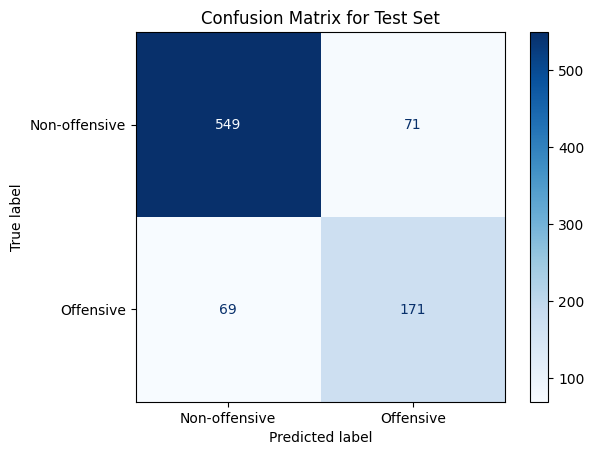

In [13]:
# Step 9: Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-offensive", "Offensive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Test Set")
plt.grid(False)
plt.show()


In [14]:

# Step 10: Save and Predict Custom Input
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_offensive(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return "Offensive" if pred == 1 else "Non-offensive"

# Try it
comment = input("Enter a tweet: ")
print("Predicted Class:", predict_offensive(comment))





Enter a tweet: I like your discussion
Predicted Class: Non-offensive


# Conclusion:
# The fine-tuned BERT model effectively classifies tweets as "Offensive" or "Non-offensive" with high overall accuracy.
# This project demonstrates the potential of transformer models for automated content moderation on social media.
# Further improvements could involve addressing class imbalance and exploring more advanced fine-tuning strategies.